# Autoencoders demo

In [1]:
import config
import data_utils
from get_dataset import fetch_dataset
from losses import MSELoss_, VAELoss
from train_util import TrainUtility
from vanilla_ae import VanillaAutoencoder
from vae import VariationalAutoencoder

from torch.utils.data import DataLoader
import torch
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn')

from matplotlib import animation, rc
rc('animation', html='html5')

## Loading data

In [2]:
data, attrs = fetch_dataset()
X_train, X_val, train_idx, val_idx = data_utils.train_test_split_seq(data)

In [3]:
X_train.shape, X_val.shape

((10000, 64, 64, 3), (3143, 64, 64, 3))

In [4]:
labels, binarizer = data_utils.get_labels_from_attrs(attrs, ['Frowning', 'Smiling'])
X_train_labels = labels[train_idx]
X_val_labels = labels[val_idx]

In [5]:
attr_train = {'labels': X_train_labels, 'binarizer': binarizer}
attr_valid = {'labels': X_val_labels, 'binarizer': binarizer}
train_dataset = data_utils.FaceDataset(X_train, attr=attr_train)
valid_dataset = data_utils.FaceDataset(X_val, attr=attr_valid)

In [6]:
train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=config.batch_size)
dataloaders = {'train': train_loader, 'valid': valid_loader}

## Autoencoder

In [7]:
ae = VanillaAutoencoder(input_size=config.input_size, latent_dim=config.ae_latent_dim, 
                        hid=config.ae_hid, device=config.device).to(config.device)
criterion = MSELoss_()
optimizer = torch.optim.Adam(ae.parameters(), lr=1e-4)

### Training

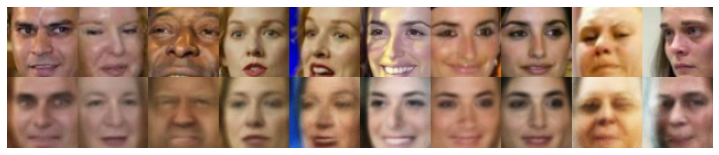

100%|██████████| 50/50 [14:58<00:00, 17.96s/it]

|| epoch loss: 0.0041


In [8]:
train_utility_ae = TrainUtility(ae, dataloaders, criterion, optimizer, epochs=50)

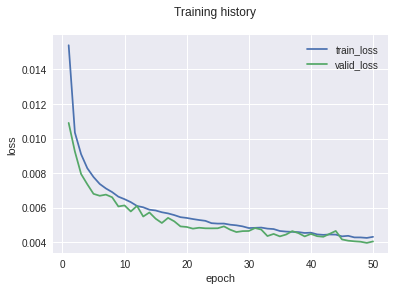

In [9]:
train_utility_ae.plot_history()

In [ ]:
anim_ae = train_utility_ae.make_anim()

### Sampling

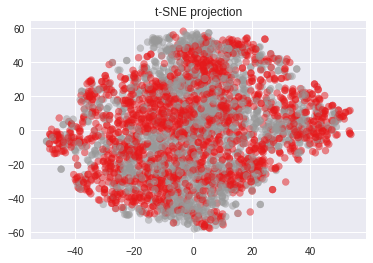

In [11]:
emb = train_utility_ae.get_2d_embeddings(show=True)

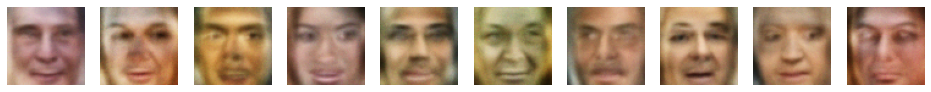

In [12]:
rand_ae = ae.sample(10)
data_utils.plot_gallery(rand_ae, n_row=1, n_col=10)

## Variational autoencoder

In [13]:
vae = VariationalAutoencoder(input_size=config.input_size, latent_dim=config.vae_latent_dim, 
                           enc_cfg=config.enc_cfg_vae, dec_cfg=config.dec_cfg_vae, 
                           restore_size=config.restore_size_vae, device=config.device).to(config.device)
criterion = VAELoss()
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-4)

### Training

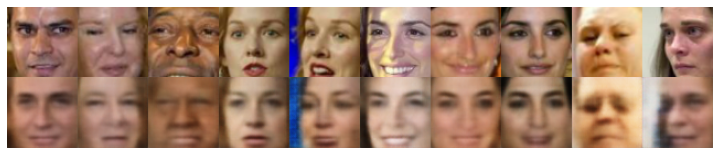

100%|██████████| 50/50 [18:34<00:00, 22.29s/it]

|| epoch loss: 7475.3347


In [14]:
train_utility_vae = TrainUtility(vae, dataloaders, criterion, optimizer, epochs=50)

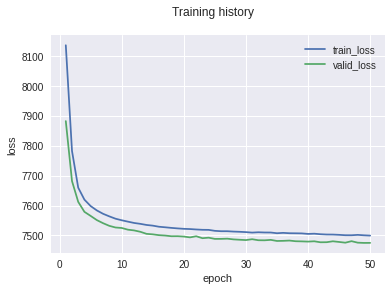

In [15]:
train_utility_vae.plot_history()

In [ ]:
anim_vae = train_utility_vae.make_anim()

### Sampling

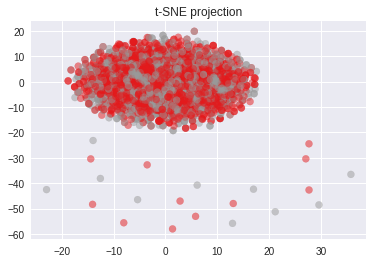

In [17]:
emb = train_utility_vae.get_2d_embeddings(show=True)

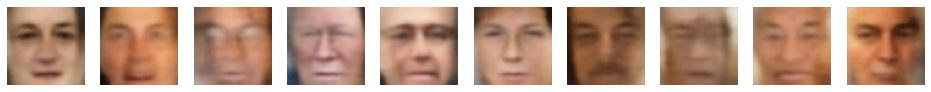

In [18]:
rand_vae = vae.sample(10)
data_utils.plot_gallery(rand_vae, n_row=1, n_col=10)

## Conditional variational autoencoder

In [19]:
cvae = VariationalAutoencoder(input_size=config.input_size, latent_dim=config.vae_latent_dim, 
                           enc_cfg=config.enc_cfg_cvae, dec_cfg=config.dec_cfg_vae, 
                           restore_size=config.restore_size_vae, n_classes=2, 
                           device=config.device).to(config.device)
criterion = VAELoss()
optimizer = torch.optim.Adam(cvae.parameters(), lr=1e-4)

### Training

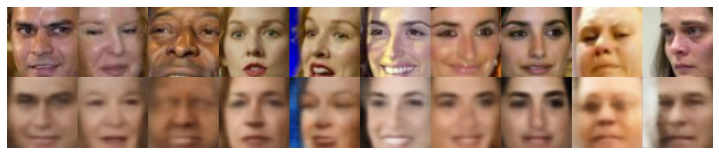

100%|██████████| 50/50 [20:10<00:00, 24.20s/it]

|| epoch loss: 7476.8259


In [20]:
train_utility_cvae = TrainUtility(cvae, dataloaders, criterion, optimizer, epochs=50)

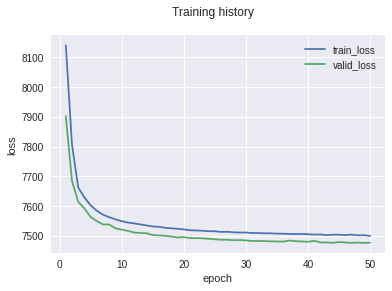

In [21]:
train_utility_cvae.plot_history()

In [ ]:
anim_cvae = train_utility_cvae.make_anim()

### Sampling

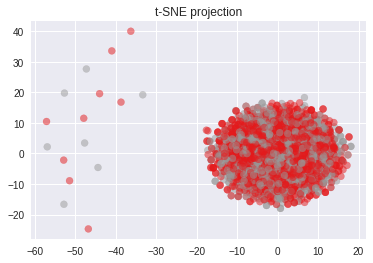

In [22]:
emb = train_utility_cvae.get_2d_embeddings(show=True)

In [28]:
frowning = torch.zeros((10, 1)).to(config.device)
smiling = torch.ones((10, 1)).to(config.device)
label = torch.cat((frowning, smiling), dim=0)
rand_cvae = cvae.sample(20, label=label)

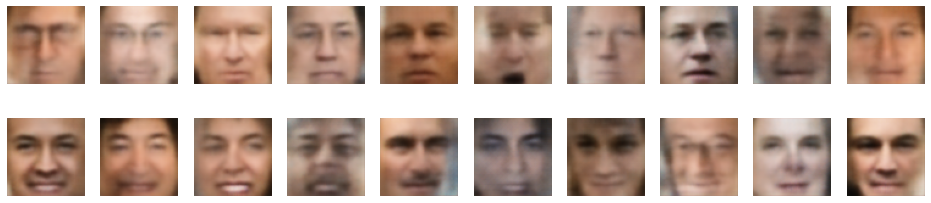

In [29]:
data_utils.plot_gallery(rand_cvae, n_row=2, n_col=10)

## Applications

### Adding a smile

In [30]:
def make_pairs(x1, y1):
    pairs = []
    for x, y in zip(x1, y1):
        pairs += [x, y]
    return pairs

In [31]:
condition = valid_dataset.sample_by_condition(n=64)
frowning, smiling = condition[0], condition[1]

#### Autoencoder

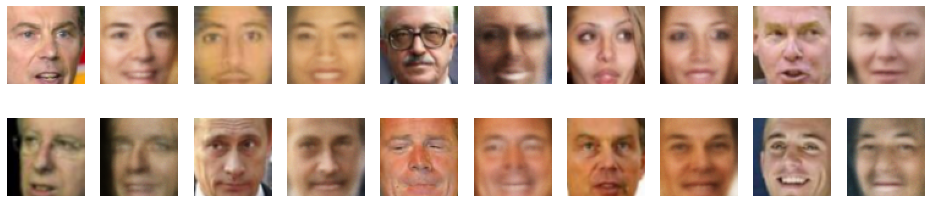

In [32]:
frowning_fixed_ae = ae.add_feature(frowning, smiling)
in_out_ae = make_pairs(frowning, frowning_fixed_ae)
data_utils.plot_gallery(in_out_ae, n_row=2, n_col=10)

#### Variational autoencoder

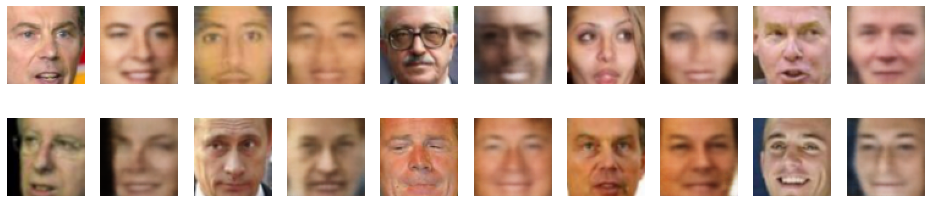

In [33]:
frowning_fixed_vae = vae.add_feature(frowning, smiling)
in_out_vae = make_pairs(frowning, frowning_fixed_vae)
data_utils.plot_gallery(in_out_vae, n_row=2, n_col=10)

### Image morphing

In [34]:
tst = next(iter(valid_loader))
idx1, idx2 = np.random.choice(len(tst), replace=False, size=2)
img1, img2 = list(map(lambda x: x.unsqueeze(0), tst['feature'][[idx1, idx2]]))

#### Autoencoder

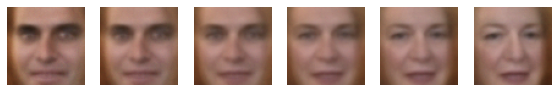

In [35]:
seq_ae = [ae.morphing(img1, img2, alpha) for alpha in np.arange(0, 1.2, 0.2)]
data_utils.plot_gallery(torch.cat(seq_ae, dim=0))

#### Variational autoencoder

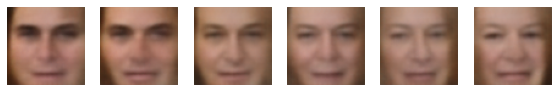

In [36]:
seq_vae = [vae.morphing(img1, img2, alpha) for alpha in np.arange(0, 1.2, 0.2)]
data_utils.plot_gallery(torch.cat(seq_vae, dim=0))

### Image retrieval

#### Autoencoder

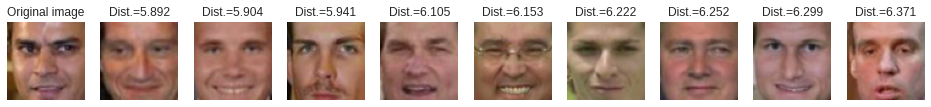

In [37]:
dist1, imgs1 = train_utility_ae.get_similar(X_val[0], n_neighbors=9)

#### Variational autoencoder

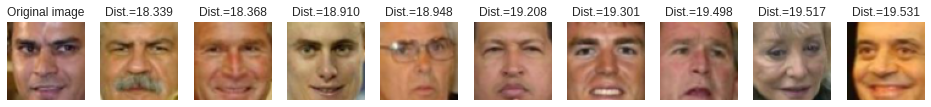

In [39]:
dist2, imgs2 = train_utility_vae.get_similar(X_val[0], n_neighbors=9)

### Denoising

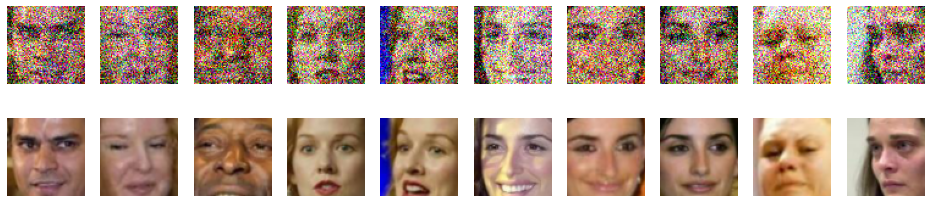

In [ ]:
noise_factor = 0.3
noisy_train = data_utils.FaceDataset(X_train, noise=noise_factor)
noisy_valid = data_utils.FaceDataset(X_val, noise=noise_factor)

train_loader_n = DataLoader(noisy_train, batch_size=config.batch_size, shuffle=True)
valid_loader_n = DataLoader(noisy_valid, batch_size=config.batch_size)
dataloaders_n = {'train': train_loader_n, 'valid': valid_loader_n}

tst = next(iter(valid_loader_n))
tst_out = torch.cat((tst['feature'][:10], tst['loss_img'][:10]), dim=0)
data_utils.plot_gallery(tst_out)

#### Autoencoder

In [ ]:
denoising_ae = VanillaAutoencoder(input_size=config.input_size, latent_dim=config.ae_latent_dim, 
                                  hid=config.ae_hid, device=config.device).to(config.device)
criterion = MSELoss_()
optimizer = torch.optim.Adam(denoising_ae.parameters(), lr=1e-4)

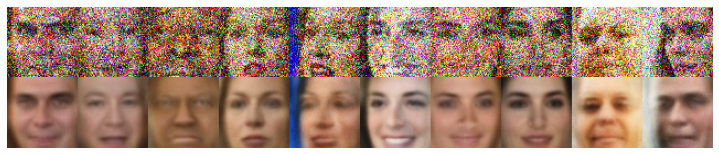

100%|██████████| 50/50 [21:29<00:00, 25.79s/it]

|| epoch loss: 0.0045


In [ ]:
train_utility_dae = TrainUtility(denoising_ae, dataloaders_n, criterion, optimizer, epochs=50)

In [ ]:
train_utility_dae.plot_history()

In [ ]:
anim_dae = train_utility_dae.make_anim()

#### Variational autoencoder

In [ ]:
denoising_vae = VariationalAutoencoder(input_size=config.input_size, latent_dim=config.vae_latent_dim, 
                           enc_cfg=config.enc_cfg_vae, dec_cfg=config.dec_cfg_vae, 
                           restore_size=config.restore_size_vae, device=config.device).to(config.device)
criterion = VAELoss()
optimizer = torch.optim.Adam(denoising_vae.parameters(), lr=1e-4)

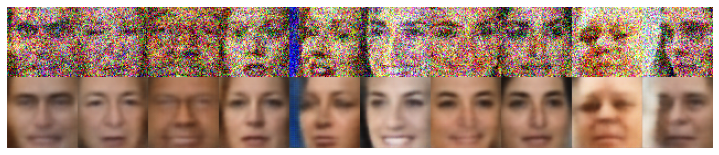

100%|██████████| 50/50 [25:46<00:00, 30.94s/it]

|| epoch loss: 7494.7852


In [ ]:
train_utility_dvae = TrainUtility(denoising_vae, dataloaders_n, criterion, optimizer, epochs=50)

In [ ]:
train_utility_dvae.plot_history()

In [ ]:
anim_dvae = train_utility_dvae.make_anim()

### Occlusion

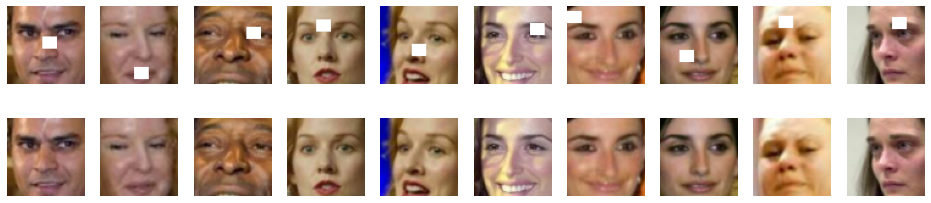

In [ ]:
rect = (10, 12)
occluded_train = data_utils.FaceDataset(X_train, occlusion=rect)
occluded_valid = data_utils.FaceDataset(X_val, occlusion=rect)

train_loader_o = DataLoader(occluded_train, batch_size=config.batch_size, shuffle=True)
valid_loader_o = DataLoader(occluded_valid, batch_size=config.batch_size)
dataloaders_o = {'train': train_loader_o, 'valid': valid_loader_o}

tst = next(iter(valid_loader_o))
tst_out = torch.cat((tst['feature'][:10], tst['loss_img'][:10]), dim=0)

data_utils.plot_gallery(tst_out)

#### Autoencoder

In [ ]:
occluded_ae = VanillaAutoencoder(input_size=config.input_size, latent_dim=config.ae_latent_dim, 
                                 hid=config.ae_hid, device=config.device).to(config.device)
criterion = MSELoss_()
optimizer = torch.optim.Adam(occluded_ae.parameters(), lr=1e-4)

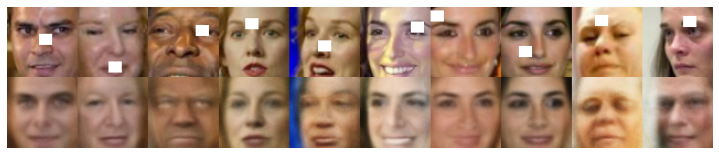

100%|██████████| 50/50 [11:32<00:00, 13.84s/it]

|| epoch loss: 0.0048


In [ ]:
train_utility_oae = TrainUtility(occluded_ae, dataloaders_o, criterion, optimizer, epochs=50)

In [ ]:
train_utility_oae.plot_history()

In [ ]:
anim_oae = train_utility_oae.make_anim()

#### Variational autoencoder

In [ ]:
occluded_vae = VariationalAutoencoder(input_size=config.input_size, latent_dim=config.vae_latent_dim, 
                           enc_cfg=config.enc_cfg_vae, dec_cfg=config.dec_cfg_vae, 
                           restore_size=config.restore_size_vae, device=config.device).to(config.device)
criterion = VAELoss()
optimizer = torch.optim.Adam(occluded_vae.parameters(), lr=1e-4)

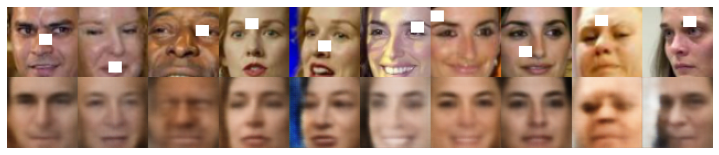

100%|██████████| 50/50 [15:22<00:00, 18.45s/it]

|| epoch loss: 7480.2701


In [ ]:
train_utility_ovae = TrainUtility(occluded_vae, dataloaders_o, criterion, optimizer, epochs=50)

In [ ]:
train_utility_ovae.plot_history()

In [ ]:
anim_ovae = train_utility_ovae.make_anim()